# ✍Anomaly Detection 이란

"An anomaly is an observation that deviates considerably from some concept of normality"

즉, 정상의 범주에서 벗어나 있는 모든 것들을 Anomaly라고 정의합니다. 

사이버 보안, 의학 분야, 금융 분야, 행동 패턴 등 다양한 분야에 적용될 수 있습니다. 

대표적인 예로 신용카드 사기, 사이버 침입, 테러 행위 같은 악의적 행동이나 시스템 고장, 비정상적인 상황 등에 활용됩니다. 



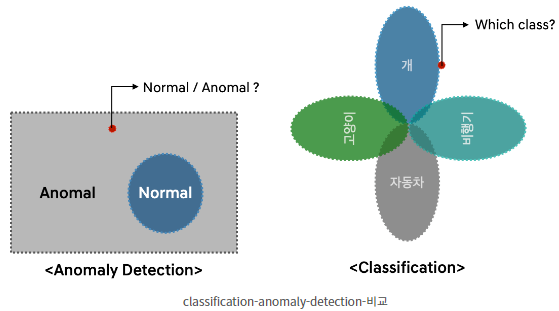

**이상 탐지**는 종종 **분류(Classification)**문제와 혼동되는데, 둘은 서로 다른 방법입니다. 

**분류**는 각 클래스를 구분할 수 있는 경계면을 찾는 것인 반면,

**이상 탐지**는 다수의 정상에서 소수의 이상을 탐지하는 것이라고 볼 수 있습니다.

### 아래 예시에서 두 방법의 차이를 살펴보겠습니다. 

## ▶ (CODE) CWRU_Dataset_Classification

사용한 데이터는 CWRU 데이터 (Case Western Reserve University Bearing Data Center) 입니다. 

In [41]:
# Data science libraries
from  scipy import *
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import easydict

# Pytorch
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

from helper import get_df_all, download
from train_helper import get_dataloader, fit, validate 
import nn_model
from data_urls import URLS
import Models


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1. Univariate 데이터 준비

[Train Data Set]

(0,1,2)라벨 데이터 각각 (786, 768, 1365)개 

In [3]:
working_dir = Path('.')
DATA_PATH = Path("./Data")
save_model_path = working_dir / 'Model'
DE_path = DATA_PATH / '12k_DE'

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [80]:
#### HYPERPARAMETERS ####
segment_length = 500

args = easydict.EasyDict({
    'batch_size':64,
    'learning_rate':0.001,
    'wd': 1e-5,
    'betas': (0.99, 0.999),
    'num_epochs': 500, 
    'seq_len': segment_length,
    'AE_channels':[segment_length, segment_length//2, segment_length//4],
    'CAE_channels':[segment_length, segment_length//2, segment_length//4],
    #'CAE_channels':[64,32,16],
    'CAE_kernel_size':[1,1], 
    'random_seed': 42
})

In [29]:
df_all = get_df_all(DE_path, segment_length=args.seq_len, normalize=True) # (14592, 502)
features = df_all.columns[2:]
target = 'label'

In [19]:
df_all1 = df_all.copy() # 정상 데이터용

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(df_all[features], 
                                                      df_all[target], 
                                                      test_size=0.20, random_state=args.random_seed, shuffle=True
                                                     )

In [31]:
# Create DataLoader of train and validation set
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, args.batch_size)

### 2.모델 준비

: 2 layer 1D CNN 모델 사용했습니다.

In [8]:
## Instantiate model, optimizer and loss function
model = nn_model.CNN_1D_2L(args.seq_len)
model.to(device)
opt = optim.Adam(model.parameters(), lr=args.learning_rate, betas=args.betas, weight_decay=args.wd)
loss_func = CrossEntropyLoss()

In [9]:
%%time
## Train
model, metrics = fit(args.num_epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 0.01165 	 0.28421 	 0.00000 	0.91093 	
1 	 0.00348 	 0.36310 	 0.00000 	0.88558 	
2 	 0.00223 	 0.21651 	 0.00000 	0.92943 	
3 	 0.00133 	 0.12153 	 0.00000 	0.96471 	
4 	 0.00102 	 0.11157 	 0.00000 	0.95752 	
5 	 0.00066 	 0.08967 	 0.00000 	0.96643 	
6 	 0.00065 	 0.04958 	 0.00000 	0.98493 	
7 	 0.00064 	 0.06898 	 0.00000 	0.97431 	
8 	 0.00091 	 0.08846 	 0.00000 	0.96677 	
9 	 0.00061 	 0.13851 	 0.00000 	0.95786 	
10 	 0.00046 	 0.09632 	 0.00000 	0.97533 	
11 	 0.00049 	 0.10729 	 0.00000 	0.97465 	
12 	 0.00058 	 0.08536 	 0.00000 	0.97568 	
13 	 0.00079 	 0.01590 	 0.00000 	0.99452 	
14 	 0.00049 	 0.10246 	 0.00000 	0.96369 	
15 	 0.00054 	 0.01800 	 0.00000 	0.99418 	
16 	 0.00033 	 0.05549 	 0.00000 	0.98767 	
17 	 0.00026 	 0.04778 	 0.00000 	0.98287 	
18 	 0.00043 	 0.07371 	 0.00000 	0.97636 	
19 	 0.00041 	 0.04553 	 0.00000 	0.98356 	
20 	 0.00035 	 0.09768 	 0.00000 	0.97259 	
21 	 0.00039 	 0.03970 	 0.00000

184 	 0.00006 	 0.00667 	 0.00000 	0.99760 	
185 	 0.00004 	 0.03509 	 0.00000 	0.99041 	
186 	 0.00004 	 0.01260 	 0.00000 	0.99726 	
187 	 0.00002 	 0.02991 	 0.00000 	0.99109 	
188 	 0.00003 	 0.01664 	 0.00000 	0.99520 	
189 	 0.00003 	 0.01541 	 0.00000 	0.99726 	
190 	 0.00003 	 0.01723 	 0.00000 	0.99589 	
191 	 0.00007 	 0.01430 	 0.00000 	0.99555 	
192 	 0.00010 	 0.03642 	 0.00000 	0.99281 	
193 	 0.00007 	 0.01603 	 0.00000 	0.99760 	
194 	 0.00008 	 0.02967 	 0.00000 	0.99281 	
195 	 0.00012 	 0.01760 	 0.00000 	0.99555 	
196 	 0.00010 	 0.03423 	 0.00000 	0.99246 	
197 	 0.00008 	 0.06593 	 0.00000 	0.98424 	
198 	 0.00012 	 0.03209 	 0.00000 	0.98869 	
199 	 0.00007 	 0.02290 	 0.00000 	0.99246 	
CPU times: total: 11min 40s
Wall time: 11min 45s


### 3. 모델 평가

모델은 2개의 층으로 쌓은 2-layer 1D CNN모델을 사용합니다.  

CNN은 원본 데이터를 2차원으로 놓고 필터라는 사각형 윈도우를 씌운 후, 데이터의 특징을 추출하는 것인데 이렇게 움직이는 과정을 convolution이라고 합니다. 

이때 필터가 움직이는 방향이 한 방향이면 1D-CNN이고, 두 방향이면 2D-CNN입니다. 

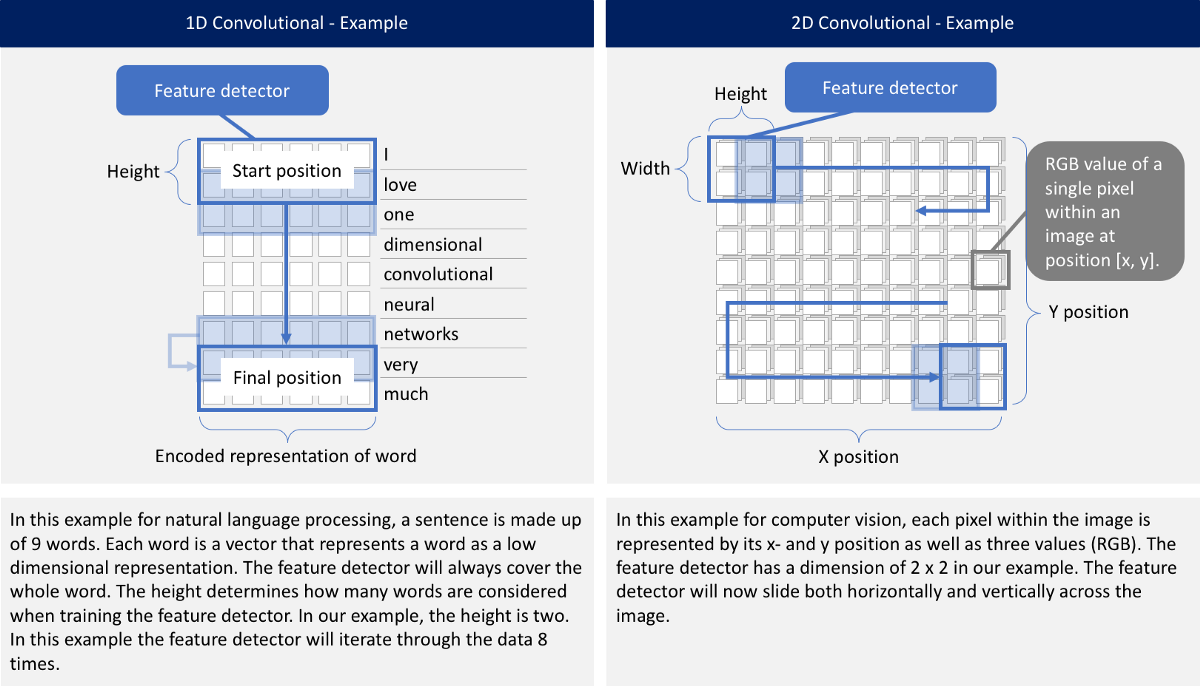

In [14]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [15]:
model2 = nn_model.CNN_1D_2L(args.seq_len) 

In [16]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()
model2.to(device)

CNN_1D_2L(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=16000, out_features=4, bias=True)
)

In [17]:
%%time
print(validate(model2, valid_dl, loss_func))

(0.022900061582959486, 0.9924631723192874, (array([2, 3, 1, ..., 3, 1, 3], dtype=int64), array([2, 3, 1, ..., 3, 3, 3], dtype=int64)))
CPU times: total: 281 ms
Wall time: 271 ms


## ▶  (CODE) CWRU_Dataset_Anomaly Detection 

### 1. Univariate 데이터 준비
[Train Data Set]

(0)라벨 데이터만 (3847)개 학습

In [39]:
# train 따로 만들기
df_all1 = df_all1[df_all1['label'] == 1] # 정상 데이터만

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(df_all1[features], 
                                                      df_all1[target], 
                                                      test_size=0.01, random_state=args.random_seed, shuffle=True
                                                     )

X_train = torch.tensor(X_train_1.values, dtype=torch.float32)
y_train = torch.tensor(y_train_1.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, args.batch_size)

In [47]:
print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([3847, 500]) torch.Size([3847]) torch.Size([2919, 500]) torch.Size([2919])


### 2. 모델 준비

In [21]:
## Instantiate model, optimizer and loss function
model = nn_model.CNN_1D_2L(args.seq_len)
model.to(device)
opt = optim.Adam(model.parameters(), lr=args.learning_rate, betas=args.betas, weight_decay=args.wd)
loss_func = CrossEntropyLoss()

In [22]:
%%time
## Train
model, metrics = fit(args.num_epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 0.00038 	 87.46120 	 0.00000 	0.26927 	
1 	 0.00000 	 122.84370 	 0.00000 	0.26927 	
2 	 0.00000 	 140.14418 	 0.00000 	0.26927 	
3 	 0.00000 	 153.23716 	 0.00000 	0.26927 	
4 	 0.00000 	 159.91450 	 0.00000 	0.26927 	
5 	 0.00000 	 164.40906 	 0.00000 	0.26927 	
6 	 0.00000 	 162.42147 	 0.00000 	0.26927 	
7 	 0.00000 	 166.69618 	 0.00000 	0.26927 	
8 	 0.00000 	 164.84679 	 0.00000 	0.26927 	
9 	 0.00000 	 165.22549 	 0.00000 	0.26927 	
10 	 0.00000 	 164.18580 	 0.00000 	0.26927 	
11 	 0.00000 	 160.67992 	 0.00000 	0.26927 	
12 	 0.00000 	 163.17087 	 0.00000 	0.26927 	
13 	 0.00000 	 161.25269 	 0.00000 	0.26927 	
14 	 0.00000 	 159.86839 	 0.00000 	0.26927 	
15 	 0.00000 	 157.03583 	 0.00000 	0.26927 	
16 	 0.00000 	 159.40449 	 0.00000 	0.26927 	
17 	 0.00000 	 156.35979 	 0.00000 	0.26927 	
18 	 0.00000 	 154.77185 	 0.00000 	0.26927 	
19 	 0.00000 	 158.82659 	 0.00000 	0.26927 	
20 	 0.00000 	 155.75100 	 0.00000 	0

179 	 0.00000 	 12.07208 	 0.00000 	0.26927 	
180 	 0.00000 	 12.02962 	 0.00000 	0.26927 	
181 	 0.00000 	 11.99048 	 0.00000 	0.26927 	
182 	 0.00000 	 11.95281 	 0.00000 	0.26927 	
183 	 0.00000 	 11.91065 	 0.00000 	0.26927 	
184 	 0.00000 	 11.87406 	 0.00000 	0.26927 	
185 	 0.00000 	 11.82872 	 0.00000 	0.26927 	
186 	 0.00000 	 11.78518 	 0.00000 	0.26927 	
187 	 0.00000 	 11.74873 	 0.00000 	0.26927 	
188 	 0.00000 	 11.69868 	 0.00000 	0.26927 	
189 	 0.00000 	 11.65108 	 0.00000 	0.26927 	
190 	 0.00000 	 11.60734 	 0.00000 	0.26927 	
191 	 0.00000 	 11.56716 	 0.00000 	0.26927 	
192 	 0.00000 	 11.52823 	 0.00000 	0.26927 	
193 	 0.00000 	 11.50069 	 0.00000 	0.26927 	
194 	 0.00000 	 11.47519 	 0.00000 	0.26927 	
195 	 0.00000 	 11.44882 	 0.00000 	0.26927 	
196 	 0.00000 	 11.42748 	 0.00000 	0.26927 	
197 	 0.00000 	 11.39702 	 0.00000 	0.26927 	
198 	 0.00000 	 11.36881 	 0.00000 	0.26927 	
199 	 0.00000 	 11.34036 	 0.00000 	0.26927 	
CPU times: total: 4min 19s
Wall ti

### 3.모델 평가

In [23]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [24]:
model2 = nn_model.CNN_1D_2L(args.seq_len) 

In [25]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()
model2.to(device)

CNN_1D_2L(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=16000, out_features=4, bias=True)
)

In [26]:
%%time
print(validate(model2, valid_dl, loss_func))

(11.340359255237585, 0.2692702980472765, (array([2, 3, 1, ..., 3, 1, 3], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64)))
CPU times: total: 281 ms
Wall time: 269 ms


분류를 위한 train data set은 각각의 클래스에서 (786, 768, 1365)개의 데이터를 학습시켰지만, 

이상 탐지를 위한 train data set은 정상 클래스의 (3847)개의 데이터를 학습시켰다는 차이가 있다. 

결과적으로, 일반적인 분류 모델인 1D CNN을 적용했을 때 Anomaly Detection의 성능이 하락하는 것을 확인할 수 있습니다. 



### 따라서, 이상 탐지는 정상 데이터만 학습한 모델로 test에서 이상을 구분할 수 있는 모델을 사용해야 한다.

## 👆 Anomaly Detection
### 시계열 데이터에 대한 이상 탐지 방법 도식화
시계열 데이터 이상 탐지는 크게 지도 학습(Supervised Learning)기반, 비지도 학습(Unsupervised Learning)기반으로 나눌 수 있습니다. 

- **지도 학습(Supervised Learning)**은 주어진 학습 데이터셋에 정상 샘플과 비정상 샘플의 Data와 Label를 모두 활용하여 학습하는 방법입니다. 


- 따라서 높은 정확도를 요구하는 경우에 주로 사용되며, 비정상 sample을 다양하게 보유할수록 더 높은 성능을 달성할 수 있습니다. 


- 하지만 **Anomaly Detection**이 적용되는 일반적인 산업 현장에서는 정상 sample보다 비정상 sample의 발생 빈도가 현저히 적기 때문에 Class-Imbalance 문제를 자주 겪게 됩니다. 


- 또한 실시간으로 수집되는 현장 데이터에는 라벨이 없는 데이터가 많습니다. 이로 인해 Label없이 학습이 가능한 **비지도 학습(Unsupervised Learning)** 방법이 등장했습니다.


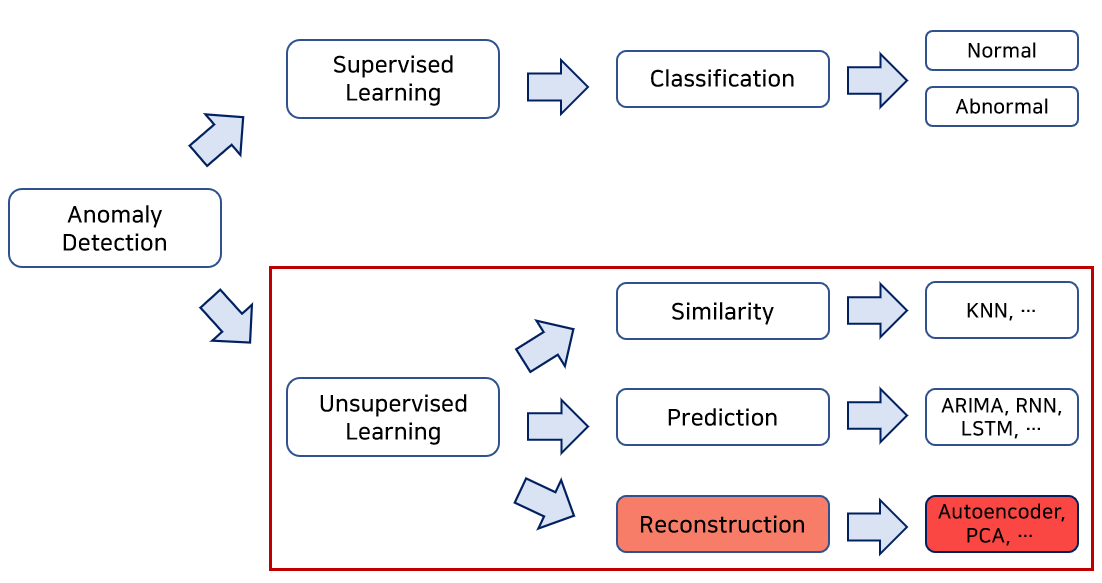

아래 코드에서는 비지도 학습 방법 중에 Reconstruction을 사용하는 Autoencoder 모델에 대해 다루겠습니다. 

## 🔆Autoencoder

#### - 입력된 데이터를 재복원하는 비지도 학습 방법론입니다. 

#### - 입력된 값과 최대한 비슷하게 출력되도록 재구성하는 것이 목표입니다. 


    ✔ Encoder: 데이터를 압축하여 중요한 정보만 살리는 latent vector로 변환

    ✔ Decoder: 압축된 latent vector를 이용하여 입력 데이터를 최대한 원본과 가깝게 복원

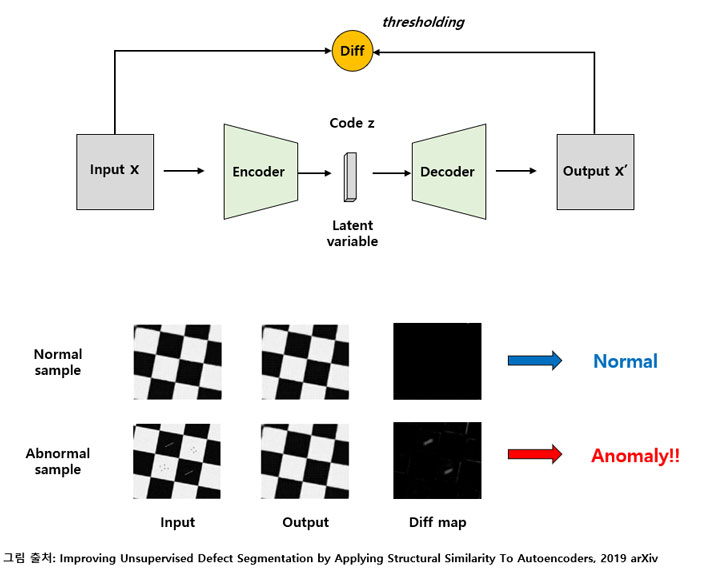

- 다만 Autoencoder의 압축 정도 같은 hyper-parameter에 따라 전반적인 복원 성능이 좌우되기 때문에 이상 탐지 정확도가 Supervised에 비해 다소 불안정하다는 단점이 존재한다. 


- 또한 autoencoder에 넣어주는 input과 output의 차이를 어떻게 정의할 것인지, 어느 loss function을 이용해 학습시킬지 등 여러 가지 요인에 따라 성능이 크게 달라질 수 있습니다. 


- 따라서, 성능에 영향을 주는 요인을 잘 조절해서 모델을 구상하는 것이 중요합니다. 

### #1. LINEAR AUTOENCODER

: Linear Autoencoder는 Linear 함수로 layer를 구성한 모델입니다. 

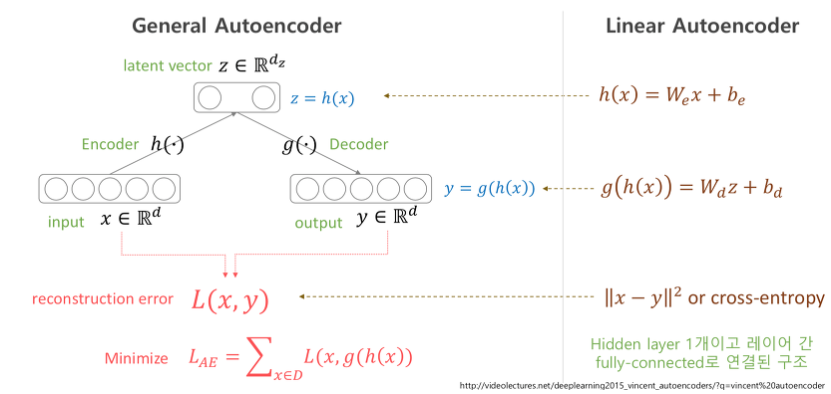

출처: https://www.slideshare.net/NaverEngineering/ss-96581209

### 1. 데이터 


위에서 정의한 CWRU 단변량 데이터 사용

In [56]:
print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([3847, 500]) torch.Size([3847]) torch.Size([2919, 500]) torch.Size([2919])


### 2. 모델 준비

In [105]:
## Instantiate model, optimizer and loss function
model = Models.AutoEncoder(args)
model.to(device)
opt = optim.Adam(model.parameters(), lr=args.learning_rate, betas=args.betas, weight_decay=args.wd)
loss_func = CrossEntropyLoss()

In [106]:
%%time
## Train
model, metrics = fit(args.num_epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 0.02878 	 7.51506 	 0.00000 	0.26927 	
1 	 0.00002 	 13.15118 	 0.00000 	0.26927 	
2 	 0.00000 	 15.22479 	 0.00000 	0.26927 	
3 	 0.00000 	 16.77443 	 0.00000 	0.26927 	
4 	 0.00000 	 17.16409 	 0.00000 	0.26927 	
5 	 0.00000 	 18.19360 	 0.00000 	0.26927 	
6 	 0.00000 	 18.08995 	 0.00000 	0.26927 	
7 	 0.00000 	 17.88213 	 0.00000 	0.26927 	
8 	 0.00000 	 18.39201 	 0.00000 	0.26927 	
9 	 0.00000 	 18.82598 	 0.00000 	0.26927 	
10 	 0.00000 	 18.67517 	 0.00000 	0.26927 	
11 	 0.00000 	 18.03401 	 0.00000 	0.26927 	
12 	 0.00000 	 18.67184 	 0.00000 	0.26927 	
13 	 0.00000 	 18.44157 	 0.00000 	0.26927 	
14 	 0.00000 	 18.39869 	 0.00000 	0.26927 	
15 	 0.00000 	 18.16090 	 0.00000 	0.26927 	
16 	 0.00000 	 18.39171 	 0.00000 	0.26927 	
17 	 0.00000 	 18.46832 	 0.00000 	0.26927 	
18 	 0.00000 	 18.03213 	 0.00000 	0.26927 	
19 	 0.00000 	 17.89896 	 0.00000 	0.26927 	
20 	 0.00000 	 18.08545 	 0.00000 	0.26927 	
21 	 0.00000

180 	 0.00000 	 12.46710 	 0.00000 	0.26927 	
181 	 0.00000 	 12.43158 	 0.00000 	0.26927 	
182 	 0.00000 	 12.54509 	 0.00000 	0.26927 	
183 	 0.00000 	 12.47448 	 0.00000 	0.26927 	
184 	 0.00000 	 12.53092 	 0.00000 	0.26927 	
185 	 0.00000 	 12.56215 	 0.00000 	0.26927 	
186 	 0.00000 	 12.46231 	 0.00000 	0.26927 	
187 	 0.00000 	 12.53466 	 0.00000 	0.26927 	
188 	 0.00000 	 12.52421 	 0.00000 	0.26927 	
189 	 0.00000 	 12.52748 	 0.00000 	0.26927 	
190 	 0.00000 	 12.57016 	 0.00000 	0.26927 	
191 	 0.00000 	 12.55362 	 0.00000 	0.26927 	
192 	 0.00000 	 12.62506 	 0.00000 	0.26927 	
193 	 0.00000 	 12.55899 	 0.00000 	0.26927 	
194 	 0.00000 	 12.56582 	 0.00000 	0.26927 	
195 	 0.00000 	 12.57566 	 0.00000 	0.26927 	
196 	 0.00000 	 12.60577 	 0.00000 	0.26927 	
197 	 0.00000 	 12.62135 	 0.00000 	0.26927 	
198 	 0.00000 	 12.65003 	 0.00000 	0.26927 	
199 	 0.00000 	 12.65700 	 0.00000 	0.26927 	
200 	 0.00000 	 12.64521 	 0.00000 	0.26927 	
201 	 0.00000 	 12.67027 	 0.00000

359 	 0.00000 	 12.92672 	 0.00000 	0.26927 	
360 	 0.00000 	 12.93048 	 0.00000 	0.26927 	
361 	 0.00000 	 12.92907 	 0.00000 	0.26927 	
362 	 0.00000 	 12.92978 	 0.00000 	0.26927 	
363 	 0.00000 	 12.92684 	 0.00000 	0.26927 	
364 	 0.00000 	 12.92817 	 0.00000 	0.26927 	
365 	 0.00000 	 12.92853 	 0.00000 	0.26927 	
366 	 0.00000 	 12.92720 	 0.00000 	0.26927 	
367 	 0.00000 	 12.92757 	 0.00000 	0.26927 	
368 	 0.00000 	 12.92978 	 0.00000 	0.26927 	
369 	 0.00000 	 12.92950 	 0.00000 	0.26927 	
370 	 0.00000 	 12.92702 	 0.00000 	0.26927 	
371 	 0.00000 	 12.92821 	 0.00000 	0.26927 	
372 	 0.00000 	 12.92962 	 0.00000 	0.26927 	
373 	 0.00000 	 12.92683 	 0.00000 	0.26927 	
374 	 0.00000 	 12.92987 	 0.00000 	0.26927 	
375 	 0.00000 	 12.92983 	 0.00000 	0.26927 	
376 	 0.00000 	 12.93180 	 0.00000 	0.26927 	
377 	 0.00000 	 12.92613 	 0.00000 	0.26927 	
378 	 0.00000 	 12.92755 	 0.00000 	0.26927 	
379 	 0.00000 	 12.92951 	 0.00000 	0.26927 	
380 	 0.00000 	 12.92679 	 0.00000

### 3.모델 평가

In [107]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [108]:
model2 = Models.AutoEncoder(args)

In [109]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()
model2.to(device)

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=500, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=250, out_features=125, bias=True)
    (4): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=125, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=250, out_features=500, bias=True)
  )
)

In [110]:
%%time
print(validate(model2, valid_dl, loss_func))

(12.939981473313084, 0.2692702980472765, (array([2, 3, 1, ..., 3, 1, 3], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64)))
CPU times: total: 62.5 ms
Wall time: 56.8 ms


### #2. RECURRENT  AUTOENCODER

: Recurrent Autoencoder는 시계열 예측에 사용되는 LSTM 모델로 layer를 구성한 모델이다. 

- 시계열 데이터의 Anomaly Detection은 시간적인 특성을 고려해야 합니다. 


- 따라서, 이전의 정보를 현재에서 활용하는 LSTM 네트워크를 사용해야 합니다. 

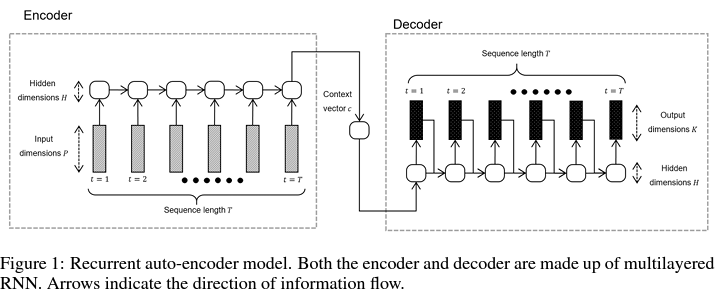

출처: Wong, T., & Luo, Z. (2018). Recurrent auto-encoder model for multidimensional time series representation.



✔ Encoder

- Encoder에서 Step t = i에서 Hidden vector는 이전 단계의 Hidden vector와 입력값을 활용하여 구합니다. 


- 마지막 Hidden vector가 Context vector c가 되어 Decoder 단계의 첫 Hidden vector로 사용합니다.


✔ Decoder

- Encoder의 입력 데이터를 역순으로 Reconstruction 합니다. 


- t = (i-1)의 Hidden vector는 이전 단계의 Hidden vector와 입력값을 활용하여 구합니다. 


✔ Objective Function

- Encoder의 입력값과 Decoder의 출력값의 차이에 대한 MSE를 최소화 하도록 학습합니다. 


In [2]:
working_dir = Path('.')
DATA_PATH = Path("./Data")
save_model_path = working_dir / 'Model'
DE_path = DATA_PATH / '12k_DE'

### Step1. 데이터 불러오기

In [3]:
arr1 = sio.loadmat(DE_path/'B007_0.mat')
data1 = {'DE_time': arr1['X118_DE_time'].squeeze(),
       'FE_time': arr1['X118_FE_time'].squeeze(),
       'BA_time': arr1['X118_BA_time'].squeeze(),
       'label': [0 for i in range(122571)]} # 정상 
df1 = pd.DataFrame(data1)
df1.shape

(122571, 4)

In [4]:
arr2 = sio.loadmat(DE_path/'OR007@3_0.mat')
data2 = {'DE_time': arr2['X144_DE_time'].squeeze(),
       'FE_time': arr2['X144_FE_time'].squeeze(),
       'BA_time': arr2['X144_BA_time'].squeeze(),
       'label': [1 for i in range(122281)]} # 이상
df2 = pd.DataFrame(data2)
df2.shape

(122281, 4)

In [5]:
df = pd.concat([df1, df2],ignore_index=True)

### Step2. 데이터 Split

In [6]:
X_train = df.iloc[:122000, :3]

X_test = df.iloc[122000:123000,:3]
y_test = df.iloc[122000:123000,-1].values


print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (122000, 3)
Test data shape: (1000, 3)


### Step3. 데이터 정규화

In [10]:
# train 데이터를 기반으로 train/validation/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [11]:
rae_X_train = scaler.transform(X_train)
rae_X_test = scaler.transform(X_test)

In [14]:
### hyper-parameter 설정
seq_len = 5
input_size = 3
hidden_size = 2

num_epochs = 500
batch_size = 32
learning_rate = 0.00001

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

### Step4. DataLoader

In [15]:
def make_time_series_dataset(X_train, X_test, y_test, seq_len):
    # train/test 데이터를 seq_len 시점 길이로 분할
    datasets = []
    for X in [X_train, X_test]:
        T = X.shape[0]
        windows = np.array([X[i:i + seq_len] for i in range(T - seq_len + 1)])
        datasets.append(windows)

    X_train, X_test = datasets[0], datasets[1]
    
    # 각 window의 마지막 시점의 label을 해당 window의 label로 사용
    y_test = np.array([y_test[i + seq_len - 1] for i in range(T - seq_len + 1)])
    
    # validation/test data 분할
    valid_idx = set(np.random.randint(0, len(X_test), int(len(X_test) * 0.4)))
    X_valid = np.array([X_test[i] for i in valid_idx])
    y_valid = np.array([y_test[i] for i in valid_idx])
    
    test_idx = set(np.arange(len(X_test))) - valid_idx
    X_test = np.array([X_test[i] for i in test_idx])
    y_test = np.array([y_test[i] for i in test_idx])
    
    return X_train, X_valid, X_test, y_valid, y_test, list(valid_idx), list(test_idx)

In [16]:
Xy = make_time_series_dataset(rae_X_train, rae_X_test, y_test, seq_len)
rae_X_train, rae_X_valid, rae_X_test, y_valid, y_test, valid_idx, test_idx = Xy

In [17]:
X_train = X_train.iloc[seq_len - 1:, ]
X_valid = X_test.iloc[valid_idx, :]
X_test = X_test.iloc[test_idx, :]

In [18]:
# train/test dataloader 생성
rae_train_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_train))
rae_train_loader = torch.utils.data.DataLoader(rae_train_dataset, batch_size=batch_size, shuffle=True)

rae_test_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_test))
rae_test_loader = torch.utils.data.DataLoader(rae_test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# validation dataloader의 경우 train/test 단계에서 사용될 loader를 따로 생성함
# train 단계: 정상으로만 구성, test 단계: 정상과 비정상으로 구성
rae_X_valid_train = rae_X_valid[y_valid == 0]
rae_valid_train_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_valid_train))
rae_valid_train_loader = torch.utils.data.DataLoader(rae_valid_train_dataset, batch_size=batch_size, shuffle=False)

rae_valid_test_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_valid))
rae_valid_test_loader = torch.utils.data.DataLoader(rae_valid_test_dataset, batch_size=batch_size, shuffle=False)

### Step5. 모델 정의

In [20]:
class RecurrentAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(RecurrentAutoEncoder, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size = hidden_size,
            hidden_size = 2 * hidden_size,
            num_layers = 1,
            batch_first = True
        )
        self.fc = nn.Linear(2 * hidden_size, input_size)
                
    def forward(self, x):
        enc_x, (enc_hidden_state, enc_cell_state) = self.encoder(x)
        enc_last_hidden = enc_hidden_state[-1, :, :]
        
        enc_last_hidden = enc_last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_x, (dec_hidden_state, dec_cell_state) = self.decoder(enc_last_hidden)
        dec_x = dec_x.reshape((x.size(0), self.seq_len, -1))
        
        out = self.fc(dec_x)
        out = torch.sigmoid(out)
        return out

In [21]:
rae_model = RecurrentAutoEncoder(input_size, hidden_size, seq_len)

### Step6. Train 데이터 학습

In [22]:
# model 학습
def train_model(dataloaders, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_loss = 10000000

    for epoch in range(num_epochs):
        if epoch == 0 or (epoch + 1) % 50 == 0:
            print()
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for i, inputs in enumerate(dataloaders[phase]):
                inputs = inputs[0].to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += inputs.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total

            if epoch == 0 or (epoch + 1) % 50 == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_valid_loss:
                best_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # validat  ion loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    print('Best validation loss: {:4f}'.format(best_valid_loss))
    model.load_state_dict(best_model_wts)
    return model

In [23]:
rae_dataloaders = {'train': rae_train_loader, 'val': rae_valid_train_loader}
rae_train_criterion = nn.MSELoss()
rae_model = train_model(rae_dataloaders, rae_model, rae_train_criterion, num_epochs, learning_rate, device)


Epoch 1/500
train Loss: 0.0159
val Loss: 0.0145

Epoch 50/500
train Loss: 0.0118
val Loss: 0.0116

Epoch 100/500
train Loss: 0.0109
val Loss: 0.0108

Epoch 150/500
train Loss: 0.0107
val Loss: 0.0107

Epoch 200/500
train Loss: 0.0106
val Loss: 0.0106

Epoch 250/500
train Loss: 0.0105
val Loss: 0.0106

Epoch 300/500
train Loss: 0.0104
val Loss: 0.0105

Epoch 350/500
train Loss: 0.0104
val Loss: 0.0105

Epoch 400/500
train Loss: 0.0104
val Loss: 0.0105

Epoch 450/500
train Loss: 0.0104
val Loss: 0.0105

Epoch 500/500
train Loss: 0.0103
val Loss: 0.0105
Best validation loss: 0.010466


### Step7. train/test 데이터의 anomaly score 도출

In [30]:
# model 검증
def test_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        test_loss = []
        for i, inputs in enumerate(data_loader):
            inputs = inputs[0].to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss = loss.reshape(loss.shape[0], -1).mean(axis=1)

            test_loss += list(loss.data.cpu().numpy())
    return test_loss

In [31]:
# train/validation/test 데이터에 대한 최종 결과 도출
rae_test_criterion = nn.L1Loss(reduction='none')
rae_train_loader = torch.utils.data.DataLoader(rae_train_dataset, batch_size=batch_size, shuffle=False)

rae_train = test_model(rae_train_loader, rae_model, rae_test_criterion, device)
rae_valid = test_model(rae_valid_test_loader, rae_model, rae_test_criterion, device)
rae_test = test_model(rae_test_loader, rae_model, rae_test_criterion, device)

### Step 8. Threshold 탐색

In [35]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [36]:
# best threshold 탐색
rae_best_threshold = search_best_threshold(rae_valid, y_valid, num_step=1000)

Best threshold:  0.1173
Best F1 Score: 0.9699


### Step 9. Best threshold를 기반으로 이상치 탐지 모형 평가

In [37]:
# 최종 결과 도출
rae_scores = pd.DataFrame(columns=['score', 'anomaly'])
for date, score in zip([X_train.index, X_valid.index, X_test.index], [rae_train, rae_valid, rae_test]):
    rae_score = pd.DataFrame(index=date)
    rae_score['score'] = score
    rae_score['anomaly'] = rae_best_threshold < score
    rae_scores = rae_scores.append(rae_score)

C:\Users\YESEUL\AppData\Local\Temp\ipykernel_6848\1383718357.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rae_scores = rae_scores.append(rae_score)
C:\Users\YESEUL\AppData\Local\Temp\ipykernel_6848\1383718357.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rae_scores = rae_scores.append(rae_score)
C:\Users\YESEUL\AppData\Local\Temp\ipykernel_6848\1383718357.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rae_scores = rae_scores.append(rae_score)


In [38]:
rae_scores = rae_scores.sort_index()
rae_scores

,score,anomaly
4,0.102933,False
5,0.089569,False
6,0.095401,False
7,0.10838,False
8,0.110491,False
...,...,...
122991,0.162962,True
122992,0.165213,True
122993,0.164207,True
122994,0.178434,True


In [41]:
# FRR, FAR, F1 score, AUROC, IE 도출
def calculate_metric(y_true, y_pred):
    # FRR, FAR
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    
    # AUROC, IE
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auroc = auc(fpr, tpr)
    ie = 1 - auroc
    
    return frr, far, f1, auroc, ie

In [42]:
frr, far, f1, auroc, ie = calculate_metric(y_test, rae_best_threshold < rae_test)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}  |  AUROC: {}  |  IE: {}"
      .format(round(frr, 4), round(far, 4), round(f1, 4), round(auroc, 4), round(ie, 4)))

**  FRR: 0.0137  |  FAR: 0.0541  |  F1 Score: 0.9639  |  AUROC: 0.9661  |  IE: 0.0339


[출처]


https://nanunzoey.tistory.com/entry/%EC%9D%B4%EC%83%81-%ED%83%90%EC%A7%80Anomaly-Detection-%EA%B8%B0%EB%B2%95%EC%9D%98-%EC%A2%85%EB%A5%98

https://ffighting.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D-Anomaly-Detection

https://sevity.tistory.com/58

https://www.cognex.com/ko-kr/blogs/deep-learning/research/anomaly-detection-overview-1-introduction-anomaly-detection


https://www.slideshare.net/NaverEngineering/ss-96581209
